In [1]:
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.transforms import CenterCrop
from torch.nn import ConvTranspose2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import ModuleList
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, jaccard_score

from imutils import paths


In [2]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f'Current device is {DEVICE}')

torch.cuda.get_arch_list()


Current device is cuda


['sm_37',
 'sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'sm_90',
 'compute_37']

In [3]:
# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the input image dimensions
INPUT_IMAGE_WIDTH = 224
INPUT_IMAGE_HEIGHT = 224

# define the path to the base output directory
BASE_OUTPUT = "output"
PATH = os.path.join(BASE_OUTPUT, "unet_val_32_50_CUDA.pth")


In [4]:
main_folder = 'C:\\Users\\krybr\\iCloudDrive\\Documents\\JupyterNotebook\\OrigDataset\\'

trainx_folder = os.path.join(main_folder, 'images\\')
trainy_folder = os.path.join(main_folder, 'masks\\')


In [5]:
trainx_paths = sorted(list(paths.list_images(trainx_folder)))
trainy_paths = sorted(list(paths.list_images(trainy_folder)))


In [6]:
x_train, x_val_test, y_train, y_val_test = train_test_split(trainx_paths, trainy_paths, test_size = 0.4, random_state = 101)


In [7]:
x_val, x_test, y_val, y_test =  train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 101)


In [8]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # return the list containing the intermediate outputs
        return blockOutputs                        

class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
            # return the final decoder output
        return x
      
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

class UNet(nn.Module):
    def __init__(self,encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), 
                 nbClasses=1, retainDim=True, 
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # return the segmentation map    
        return map


In [9]:
unet = torch.load(PATH).to(DEVICE)


In [10]:
# USAGE
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()
    

In [11]:
def make_predictions_with_plot(model, imagePath, maskPath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        orig = image.copy()
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(maskPath, 0)
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)
    

In [12]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
                
        # prepare a plot for visualization
        return predMask
    

In [13]:
def grid_imshow(mask):
    ax = plt.gca()
    plt.imshow(mask, cmap="gray" if len(mask.shape)==2 else None, interpolation="none", vmin=0, vmax=1, aspect="equal")
    
    if mask.shape[1] < 20:
        # Major ticks
        ax.set_xticks(np.arange(0, mask.shape[1], 1))
        ax.set_yticks(np.arange(0, mask.shape[0], 1))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, mask.shape[1]+1, 1))
        ax.set_yticklabels(np.arange(1, mask.shape[0]+1, 1))

        # Minor ticks
        ax.set_xticks(np.arange(-.5, mask.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, mask.shape[0], 1), minor=True)
        
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='blue', linestyle='-', linewidth=2)

    else:
        # Major ticks
        ax.set_xticks(np.arange(0, mask.shape[1], 500))
        ax.set_yticks(np.arange(0, mask.shape[0], 500))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(0, mask.shape[1], 500))
        ax.set_yticklabels(np.arange(0, mask.shape[0], 500))

        # Gridlines based on major ticks
        ax.grid(which='major', color='blue', linestyle='-', linewidth=2)

def compare_masks(gt_mask, pred_mask, gt_title="Ground Truth Mask", pred_title="Prediction Mask", _figshape=(10,10)):
    plt.figure(figsize=_figshape)

    plt.subplot(1,2,1)    
    grid_imshow(gt_mask)
    plt.title(gt_title, fontweight="bold")

    plt.subplot(1,2,2)
    grid_imshow(pred_mask)
    plt.title(pred_title, fontweight="bold")

    plt.tight_layout()
    plt.show()
    

In [14]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask) + 0.0001
    total_pixel_pred = np.sum(pred_mask) + 0.0001
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)


In [15]:
def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df


[INFO] loading up test image paths...
[INFO] load up model...


C:\Users\krybr\AppData\Local\Temp\ipykernel_7892\2887377380.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


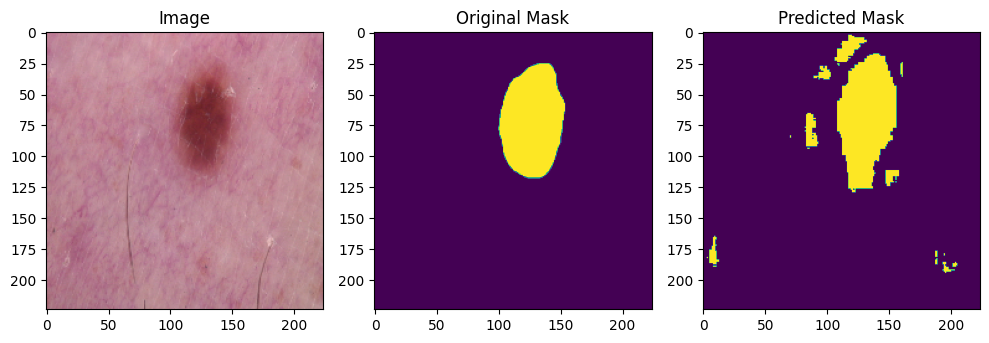

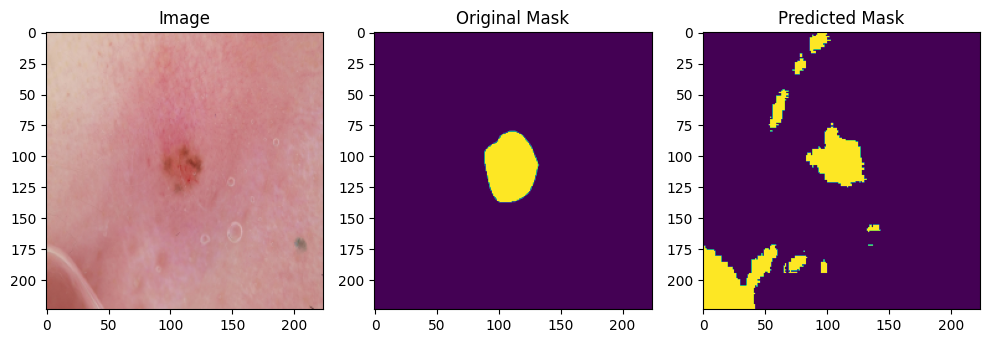

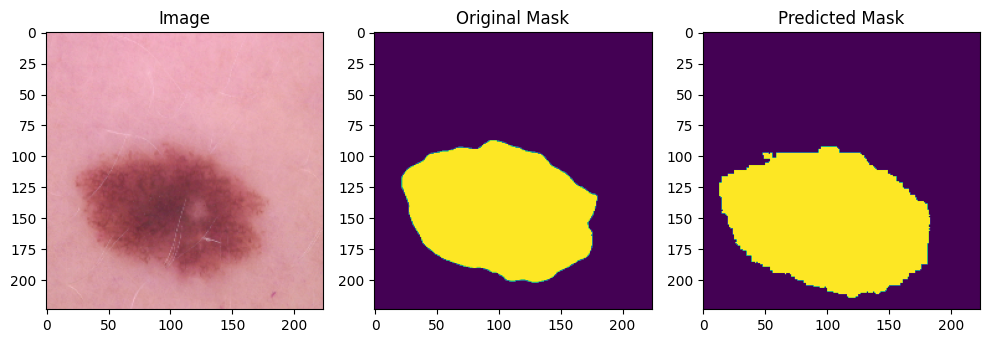

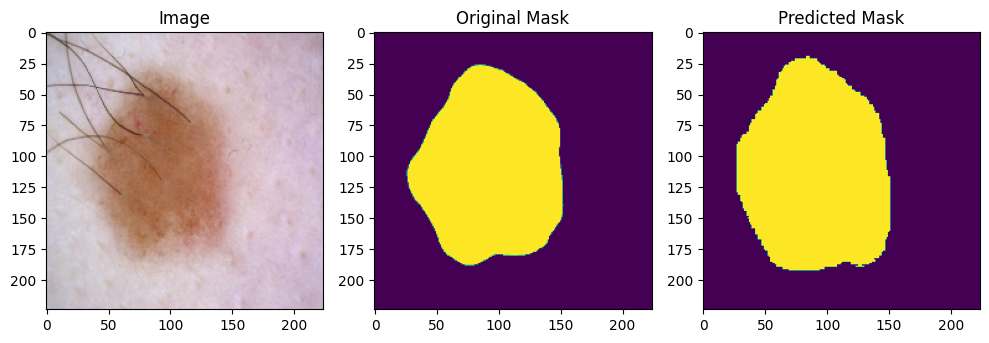

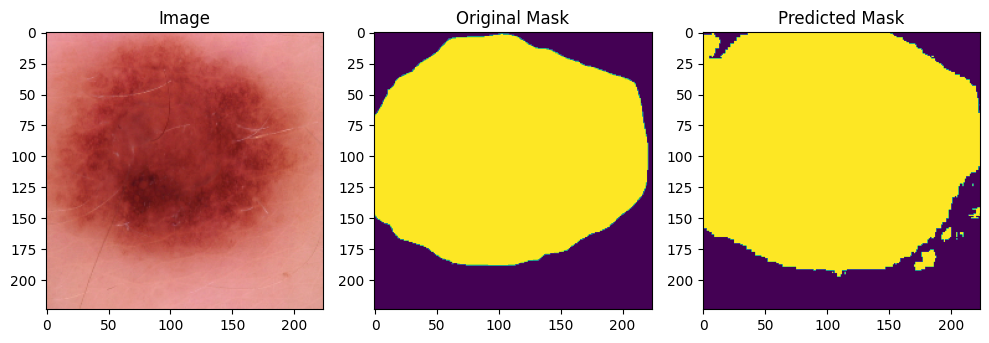

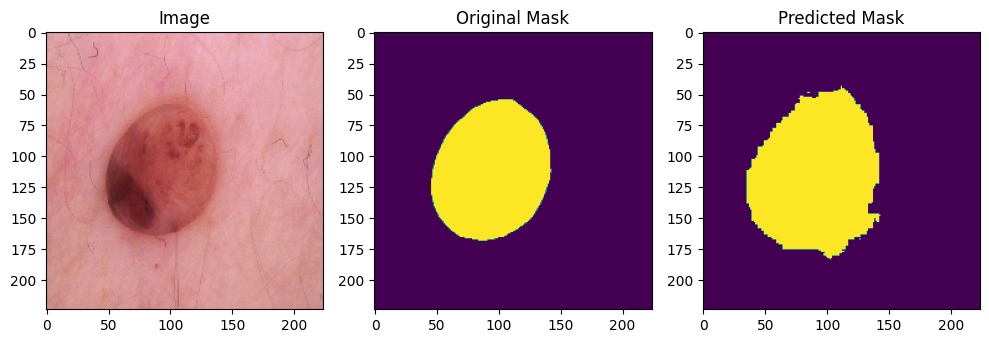

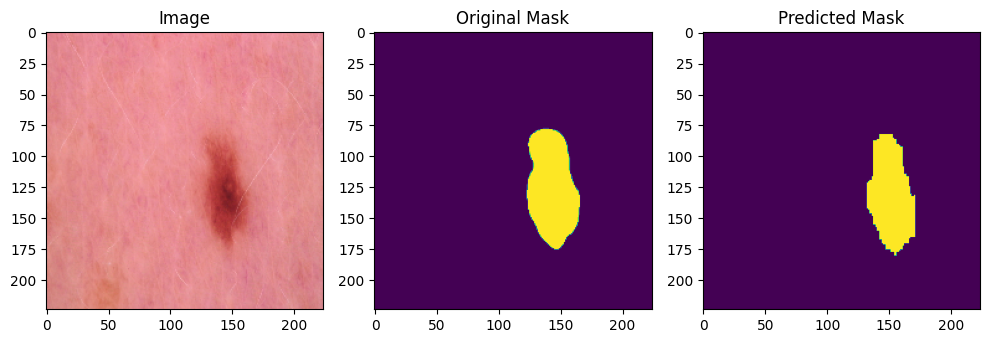

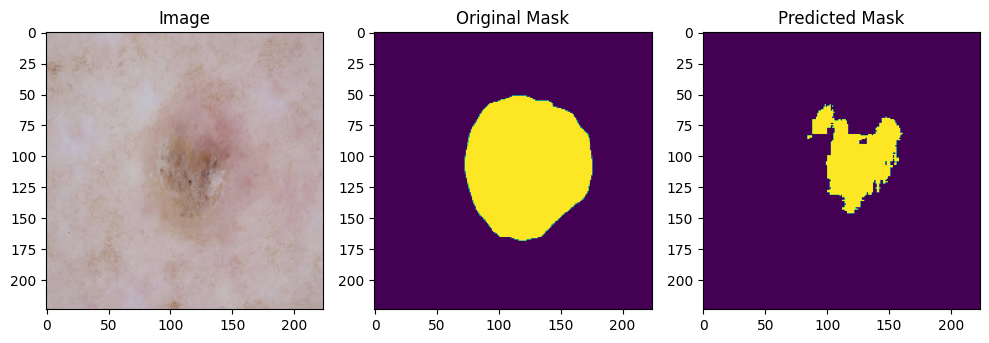

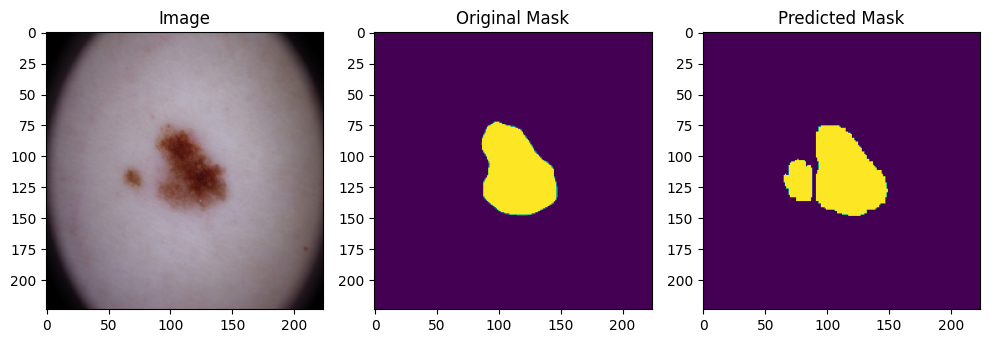

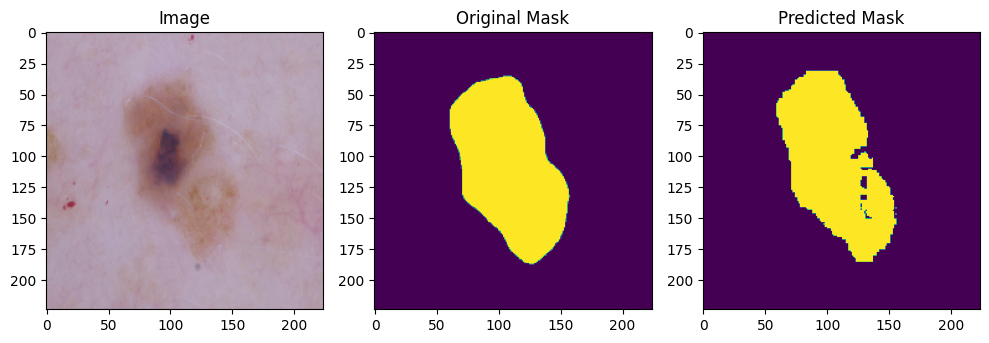

In [16]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = np.random.choice(x_test, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for i  in range(10):
    # make predictions and visualize the results
    make_predictions_with_plot(unet, x_test[i], y_test[i])
    

In [17]:
gt = pd.read_csv(os.path.join(main_folder,'GroundTruth.csv'))


In [18]:
print(gt)


              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0      ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1      ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2      ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3      ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4      ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
...             ...  ...  ...  ...    ...  ...  ...   ...
10010  ISIC_0034316  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10011  ISIC_0034317  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10012  ISIC_0034318  0.0  0.0  0.0    0.0  1.0  0.0   0.0
10013  ISIC_0034319  0.0  1.0  0.0    0.0  0.0  0.0   0.0
10014  ISIC_0034320  0.0  1.0  0.0    0.0  0.0  0.0   0.0

[10015 rows x 8 columns]


In [19]:
string_list = []

for i in range(len(x_test)):
    stripped = x_test[i][72:84]
    string_list.append(stripped)


In [20]:
# List to store strings not present in dataframe
#not_present = []

# Iterate over each string
#for string in string:
    # Check if string exists in dataframe
    #if not any(gt.isin([string]).any()):
        # String not found, add it to the list
        #not_present.append(string)    


In [21]:
filtered_gt = gt[gt['image'].isin(string_list)]


In [22]:
lesion_dict = {
    "MEL": 0, 
    "NV": 1,
    "BCC": 2,
    "AKIEC": 3,
    "BKL": 4,
    "DF": 5,
    "VASC": 6
}

new_lesion_dict = {
    0: [], 
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: []
}


In [23]:
categories = []
for index, row in filtered_gt.iterrows():
    if row.eq(1).any():
        categories.append(lesion_dict[row[row.eq(1)].index[0]])


In [24]:
tru = cv2.imread(y_test[0], 0)
tru = (cv2.resize(tru, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))) / 255

pred = make_predictions(unet, x_test[0]) /255

print(metrics_table([tru], [pred]))
    

   Precision  Recall  Accuracy   Dice    IoU
0      0.682   0.836     0.958  0.751  0.601


In [25]:
evaluations = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU'])

for i in range(len(x_test)):
    tru = cv2.imread(y_test[i], 0)
    tru = (cv2.resize(tru, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))) / 255
    pred = make_predictions(unet, x_test[i]) /255

    evaluations_new_row = metrics_table([tru], [pred])

    evaluations = pd.concat([evaluations, evaluations_new_row], ignore_index=True)


C:\Users\krybr\AppData\Local\Temp\ipykernel_7892\3548941504.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations = pd.concat([evaluations, evaluations_new_row], ignore_index=True)


In [26]:
evaluations


,Precision,Recall,Accuracy,Dice,IoU
0,0.682,0.836,0.958,0.751,0.601
1,0.314,0.662,0.934,0.426,0.270
2,0.830,0.950,0.936,0.886,0.795
3,0.883,0.979,0.955,0.928,0.866
4,0.869,0.990,0.896,0.926,0.862
...,...,...,...,...,...
1998,0.965,0.796,0.964,0.872,0.774
1999,0.638,0.982,0.804,0.773,0.630
2000,0.833,0.954,0.964,0.889,0.801
2001,0.295,0.996,0.524,0.456,0.295


In [27]:
df = pd.DataFrame(categories, columns=['Category'])


In [28]:
df


,Category
0,4
1,4
2,1
3,2
4,0
...,...
1998,4
1999,1
2000,4
2001,1


In [29]:
merged_datasets =  pd.concat([evaluations, df], axis=1)


In [30]:
merged_datasets


,Precision,Recall,Accuracy,Dice,IoU,Category
0,0.682,0.836,0.958,0.751,0.601,4
1,0.314,0.662,0.934,0.426,0.270,4
2,0.830,0.950,0.936,0.886,0.795,1
3,0.883,0.979,0.955,0.928,0.866,2
4,0.869,0.990,0.896,0.926,0.862,0
...,...,...,...,...,...,...
1998,0.965,0.796,0.964,0.872,0.774,4
1999,0.638,0.982,0.804,0.773,0.630,1
2000,0.833,0.954,0.964,0.889,0.801,4
2001,0.295,0.996,0.524,0.456,0.295,1


In [31]:
value_counts = merged_datasets['Category'].value_counts()


In [32]:
value_counts


Category
1    1330
4     232
0     221
2     108
3      63
6      30
5      19
Name: count, dtype: int64

In [33]:
# Calculate the mean value for each category in the 'category_column'
mean_precision_values = merged_datasets.groupby('Category')['Precision'].mean()
mean_recall_values = merged_datasets.groupby('Category')['Recall'].mean()
mean_accuracy_values = merged_datasets.groupby('Category')['Accuracy'].mean()
mean_dice_values = merged_datasets.groupby('Category')['Dice'].mean()
mean_iou_values = merged_datasets.groupby('Category')['IoU'].mean()


In [34]:
results = pd.concat([mean_precision_values, mean_recall_values, mean_accuracy_values, mean_dice_values, mean_iou_values], axis=1)


In [35]:
results


,Precision,Recall,Accuracy,Dice,IoU
Category,,,,,
0,0.772670,0.854787,0.876566,0.776434,0.670516
1,0.781723,0.842855,0.879532,0.776102,0.671080
2,0.796139,0.826648,0.882250,0.778435,0.665000
3,0.791952,0.858159,0.893714,0.787841,0.682968
4,0.765599,0.867017,0.879254,0.786453,0.675819
5,0.834474,0.841737,0.892368,0.815789,0.705526
6,0.763300,0.869533,0.895633,0.789167,0.677733
